# IMMUNE RESPONSE TO PNEUMOCCI

(Based on a final project submitted by Kazuki Fukumoto to BIOEN 599, March, 2024, University of Washington)

In [1]:
import controlSBML as ctl

import control
import numpy as np

# 1. Problem Statement & System Description

This model explores how the immune system responds to the infection of Pneumococci, which is the microbe associated with pneumonia. The model considers Pneumococci, susceptible epithelial cells, epithelial cells with bacteria, cytokines, neutrophils, and debris (apoptotic cellular material). The baseline simulation shows that Pneumococci are not eliminated, and all epithelial cells are eliminated. This is because the neutrophils are not produced and deployed fast enough to eliminate the infection. Even if enough neutrophils are produced, large overshoots or oscillations of neutrophils could be the factor of other health problems. To overcome these problems, I set two following control objectives.

We have two control objectives.

- Control objective 1: shortening settling time so that neutrophils [N] increases fast enought to eliminate Pneumococci [P]
- Control objective 2: having no or small overshoot of neutrophils

In this design, shorter time to reach the setpoint, small overshoot of [N], and zero or negative [P] are the goal to achive. Negative [P] doesn't make sence physically, but in this case, negative [P] is good because it indicates the elimination of P. In terms of setpoint, it is based on the maximum conc. of N with the original open loop simulation. 

The design can increase [N] quickly, and [N] reaches the setpoint. Increasing kP shortens the time to reach the setpoint. Increasing kI makes the amplitude of increase smaller, and [P] is not eliminated. Therefore, kP would be more important to achive my control objective.

## System Exploration

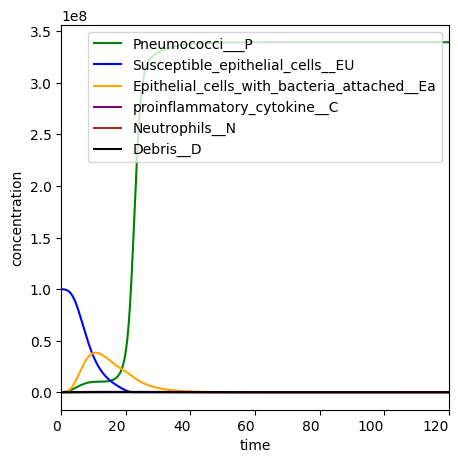

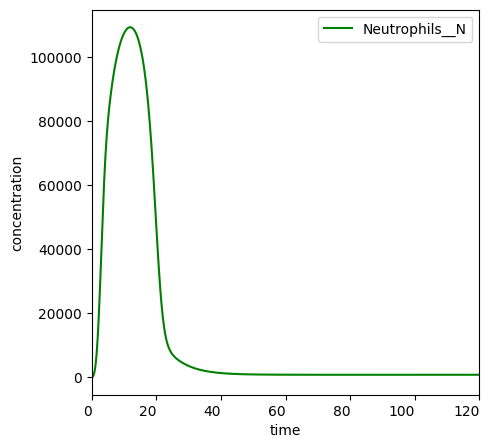

In [2]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1808280007/6/Smith2011_V1.xml"
TIMES = np.linspace(0, 120, 1200)
FIGSIZE = (5, 5)
CTLSB = ctl.ControlSBML(URL, times=TIMES, is_fixed_input_species=True, figsize=FIGSIZE)
_ = CTLSB.plotModel()
_ = CTLSB.plotModel(selections=["Neutrophils__N"])

## System Definition

We want to explore the effect of the titers of Pneumocci on netrophils.

In [3]:
INPUT_NAME = 'Pneumococci___P'
OUTPUT_NAME = 'Neutrophils__N'

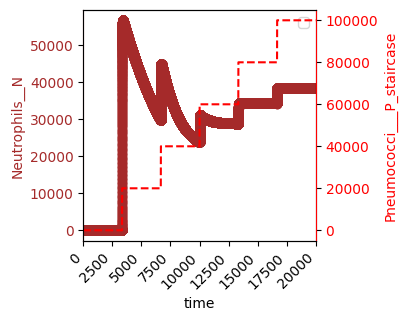

In [4]:
CTLSB = ctl.ControlSBML(URL, input_name=INPUT_NAME, output_name=OUTPUT_NAME, is_fixed_input_species=True,
                       figsize=FIGSIZE)
TIMES = np.linspace(0, 20000, 200000)
FINAL_VALUE = 100000
_ = CTLSB.plotStaircaseResponse(initial_value = 0, final_value=FINAL_VALUE, num_step=5, 
                                                    times=TIMES, figsize=(3,3), xlabel_angle=45)

We see that there is an initial transient and that a sufficiently long time is required to see the response to Pneumocci titers. A longer time horizon is needed to demonstrate the effect of the control input.

# 2. System Identification

In [5]:
FIT_START_TIME = 10000
FIT_END_TIME = TIMES[-1]

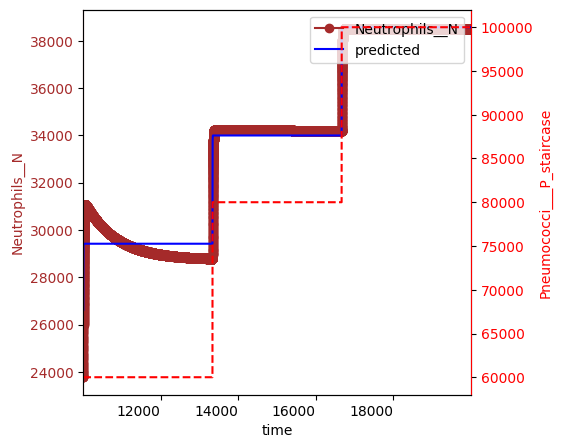

In [6]:
result = CTLSB.plotTransferFunctionFit(times=TIMES, initial_value=10, final_value=FINAL_VALUE,
    fit_start_time=FIT_START_TIME, fit_end_time=FIT_END_TIME,
    num_zero=0, num_pole=2, fitter_method="gpz")

In [7]:
TRANSFER_FUNCTION = CTLSB.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

TransferFunction(array([0.22887252]), array([0.31748021, 1.78740105, 1.        ]))

In [8]:
print("poles: ", TRANSFER_FUNCTION.poles())
print("zeros: ", TRANSFER_FUNCTION.zeros())
print("DCgain: ", TRANSFER_FUNCTION.dcgain())

poles:  [-5.        +0.j -0.62996052+0.j]
zeros:  []
DCgain:  0.22887252099188843


This isn't a bad fit over the region of interest.

# 3. Control Design

## Testbed Construction

In [ ]:
TIMES = times=np.linspace(0, 200, 2000)
SETPOINT = 1000
_ = CTLSB.plotDesign(kP_spec=1.0, kI_spec=0.1, times=10000*TIMES, xlabel_angle=45, setpoint=SETPOINT, xlabel="time (X 10e6)")

> /Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/control_sbml.py(790)plotDesign()
    788         #
    789         import pdb; pdb.set_trace()
--> 790         kP_spec=self.setSpec(kP_spec)
    791         kI_spec=self.setSpec(kI_spec)
    792         kD_spec=self.setSpec(kD_spec)



We have a massive overshoot and a very long settling time.

## Loot Rocus Analysis

We plan to use PI control. So, we do the root locus analysis for I-control to see the effect of the parameter $k_I$.

In [ ]:
s = control.TransferFunction.s
_ = control.root_locus(TRANSFER_FUNCTION/s, grid=False)

The open loop poles are negative, but with PI control, we add a pole at zero. We see $k_I$ should be small so that we move it away from 0 (towards a more negative value). But we don't want $k_I$ so large that we pass the breakaway point (since this will introduce oscillations and make the real part of the pole closer to 0).

## Grid Search

In [ ]:
grid = CTLSB.getGrid()
grid.addAxis("kP", min_value=0.5, max_value=10, num_coordinate=10)
grid.addAxis("kI", min_value=0.002, max_value=0.02, num_coordinate=10)
_ = CTLSB.plotGridDesign(grid, times=TIMES, setpoint=SETPOINT)

We show that these results are robust to the choice of setpoint.

**BUG** I should get the same output as the above plot.

In [ ]:
_ = CTLSB.plotDesign(kP_spec=CTLSB.kP, kI_spec=CTLSB.kI, times=TIMES, setpoint=SETPOINT)

By using PI control, we converge to the setpoint. With the grid search, we find design parameters that greatly reduce oscillations. 